In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [2]:
# Define the LSTM-CNN model
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, kernel_size):
        super(LSTM_CNN_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.cnn = nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # CNN layer
        cnn_out = self.cnn(lstm_out.permute(0, 2, 1))  # Conv1d expects (batch_size, in_channels, seq_len)

        cnn_out = self.relu(cnn_out)

        # Global max pooling
        pooled_out, _ = torch.max(cnn_out, 2)

        # Fully connected layer
        output = self.fc(pooled_out)

        return output

In [3]:
# Define the LSTM-CNN model
class LSTM_CNN_Model_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, kernel_size):
        super(LSTM_CNN_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.cnn1 = nn.Conv1d(in_channels=hidden_size, out_channels=32, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(32)
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(64)
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # CNN layer
        x = self.relu(self.cnn1(lstm_out.permute(0, 2, 1)))# Conv1d expects (batch_size, in_channels, seq_len)
        x = self.pool(x)
        x = self.relu(self.cnn2(x))
        x = self.pool(x)
        x = self.relu(self.cnn3(x))
        x = self.pool(x)

        # Fully connected layer
        x = self.fc(x)
        output = self.softmax(x)

        return output

In [4]:
import torch
from torch.utils.data import Dataset
import json

class EEGDataset(Dataset):
    def __init__(self, json_file, segment_length):
        with open(json_file, 'r') as file:
            data = json.load(file)

        self.data = []
        self.class_mapping = {}  # Mapping between class labels and numerical values
        self.reverse_class_mapping = {}  # Reverse mapping for numerical values to class labels
        class_counter = 0

        for subject in data['subjects']:
            for image in subject['view_images']:
                eeg_signal = image['EEG_signal']
                class_label = image['class']

                # Exclude samples with class 'no_stimuli'
                if class_label == 'no_stimuli':
                    continue

                # Segment the EEG signal
                for i in range(0, len(eeg_signal), segment_length):
                    segment = eeg_signal[i:i + segment_length]
                    if len(segment) == segment_length:
                        # Convert class labels to numerical values
                        if class_label not in self.class_mapping:
                            self.class_mapping[class_label] = class_counter
                            self.reverse_class_mapping[class_counter] = class_label
                            class_counter += 1

                        self.data.append({
                            "EEG_signal": segment,
                            "class": self.class_mapping[class_label],
                            "class_label": class_label,
                            "age": subject['age'],
                            "sex": subject['sex'],
                            "has_cat": subject['has_cat'],
                            "has_dog": subject['has_dog'],
                            "has_rabbit": subject['has_rabbit']
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        eeg_signal = torch.tensor(item['EEG_signal'], dtype=torch.float)
        return {
            "eeg_signal": eeg_signal,
            "class": item['class'],
            "class_label": item['class_label'],
            "age": item['age'],
            "sex": item['sex'],
            "has_cat": item['has_cat'],
            "has_dog": item['has_dog'],
            "has_rabbit": item['has_rabbit']
        }

In [5]:
# Hyperparameters
input_size = 16  # Assuming EEG signal is univariate, adjust if it's multivariate
hidden_size = 64
num_layers = 1
num_classes = 4  # Adjust based on your classification task
kernel_size = 3
segment_length = 123  # Adjust based on your data and model requirements

In [6]:
dataset = EEGDataset("SynapSee_data.json", segment_length)

In [7]:
# Extract features and labels
features = [item["eeg_signal"] for item in dataset]
labels = [item["class"] for item in dataset]

# Use StratifiedShuffleSplit to split the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(features, labels))

# Split dataset into train and test sets
train_dataset = torch.utils.data.Subset(dataset, train_index)
test_dataset = torch.utils.data.Subset(dataset, test_index)

# Create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
classes = []
for batch in train_dataloader:
    labels = batch["class_label"]
    classes.append(labels)

In [18]:
classes = sum(classes, [])

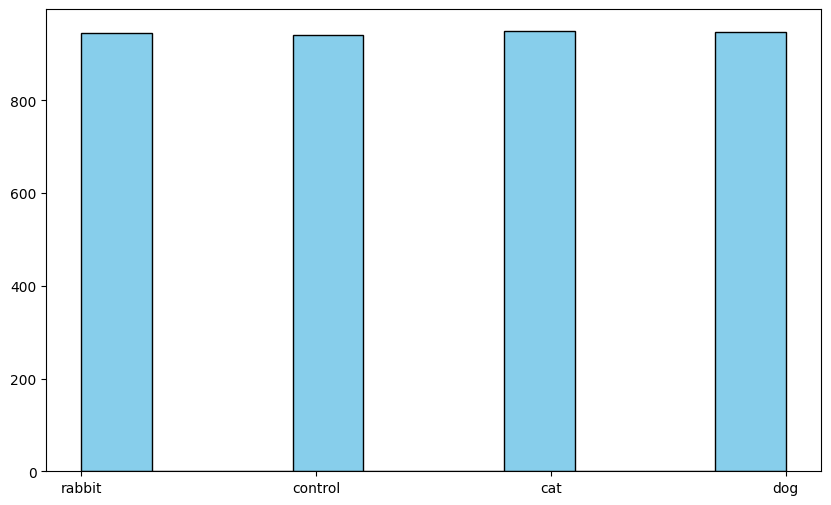

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(classes, color='skyblue', edgecolor='black')
plt.show()

In [31]:
classes = []
for batch in test_dataloader:
    labels = batch["class_label"]
    classes.append(labels)

In [32]:
classes = sum(classes, [])

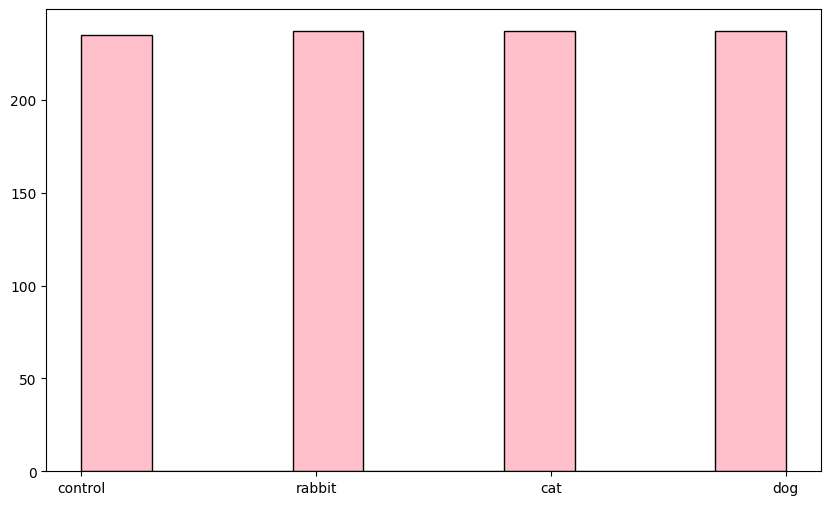

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(classes, color='pink', edgecolor='black')
plt.show()

In [ ]:
def train(model, dataloader, num_epochs=10, initial_learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for batch in dataloader:
            sequences = batch["eeg_signal"].to(device)
            labels = batch["class"].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(sequences)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # Calculate average loss per epoch
        average_loss = running_loss / len(dataloader)

        # Calculate accuracy
        epoch_accuracy = 100 * total_correct / total_samples

        loss_history.append(average_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

    print("Training complete.")
    return loss_history

In [ ]:
# Initialize model, loss function, and optimizer
model = LSTM_CNN_Model(input_size, hidden_size, num_layers, num_classes, kernel_size)

In [ ]:
loss = train(model, train_dataloader, num_epochs=2500, initial_learning_rate=0.00001)

Epoch [1/2500] - Loss: 1.3898 - Accuracy: 25.98%
Epoch [2/2500] - Loss: 1.3882 - Accuracy: 25.80%
Epoch [3/2500] - Loss: 1.3874 - Accuracy: 25.67%
Epoch [4/2500] - Loss: 1.3845 - Accuracy: 25.40%
Epoch [5/2500] - Loss: 1.3843 - Accuracy: 25.30%
Epoch [6/2500] - Loss: 1.3830 - Accuracy: 27.15%
Epoch [7/2500] - Loss: 1.3819 - Accuracy: 27.33%
Epoch [8/2500] - Loss: 1.3812 - Accuracy: 26.94%
Epoch [9/2500] - Loss: 1.3797 - Accuracy: 27.76%
Epoch [10/2500] - Loss: 1.3784 - Accuracy: 28.28%
Epoch [11/2500] - Loss: 1.3782 - Accuracy: 28.21%
Epoch [12/2500] - Loss: 1.3769 - Accuracy: 28.55%
Epoch [13/2500] - Loss: 1.3770 - Accuracy: 28.39%
Epoch [14/2500] - Loss: 1.3764 - Accuracy: 30.66%
Epoch [15/2500] - Loss: 1.3753 - Accuracy: 32.33%
Epoch [16/2500] - Loss: 1.3741 - Accuracy: 32.65%
Epoch [17/2500] - Loss: 1.3744 - Accuracy: 32.33%
Epoch [18/2500] - Loss: 1.3739 - Accuracy: 33.12%
Epoch [19/2500] - Loss: 1.3733 - Accuracy: 33.76%
Epoch [20/2500] - Loss: 1.3723 - Accuracy: 34.02%
Epoch [21

In [ ]:
def plot_loss(loss_history):
    """
    Plots the loss over time.

    Parameters:
        loss_history (list): List containing loss values for each epoch.
    """
    plt.figure(figsize=(40, 24))
    plt.plot(loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

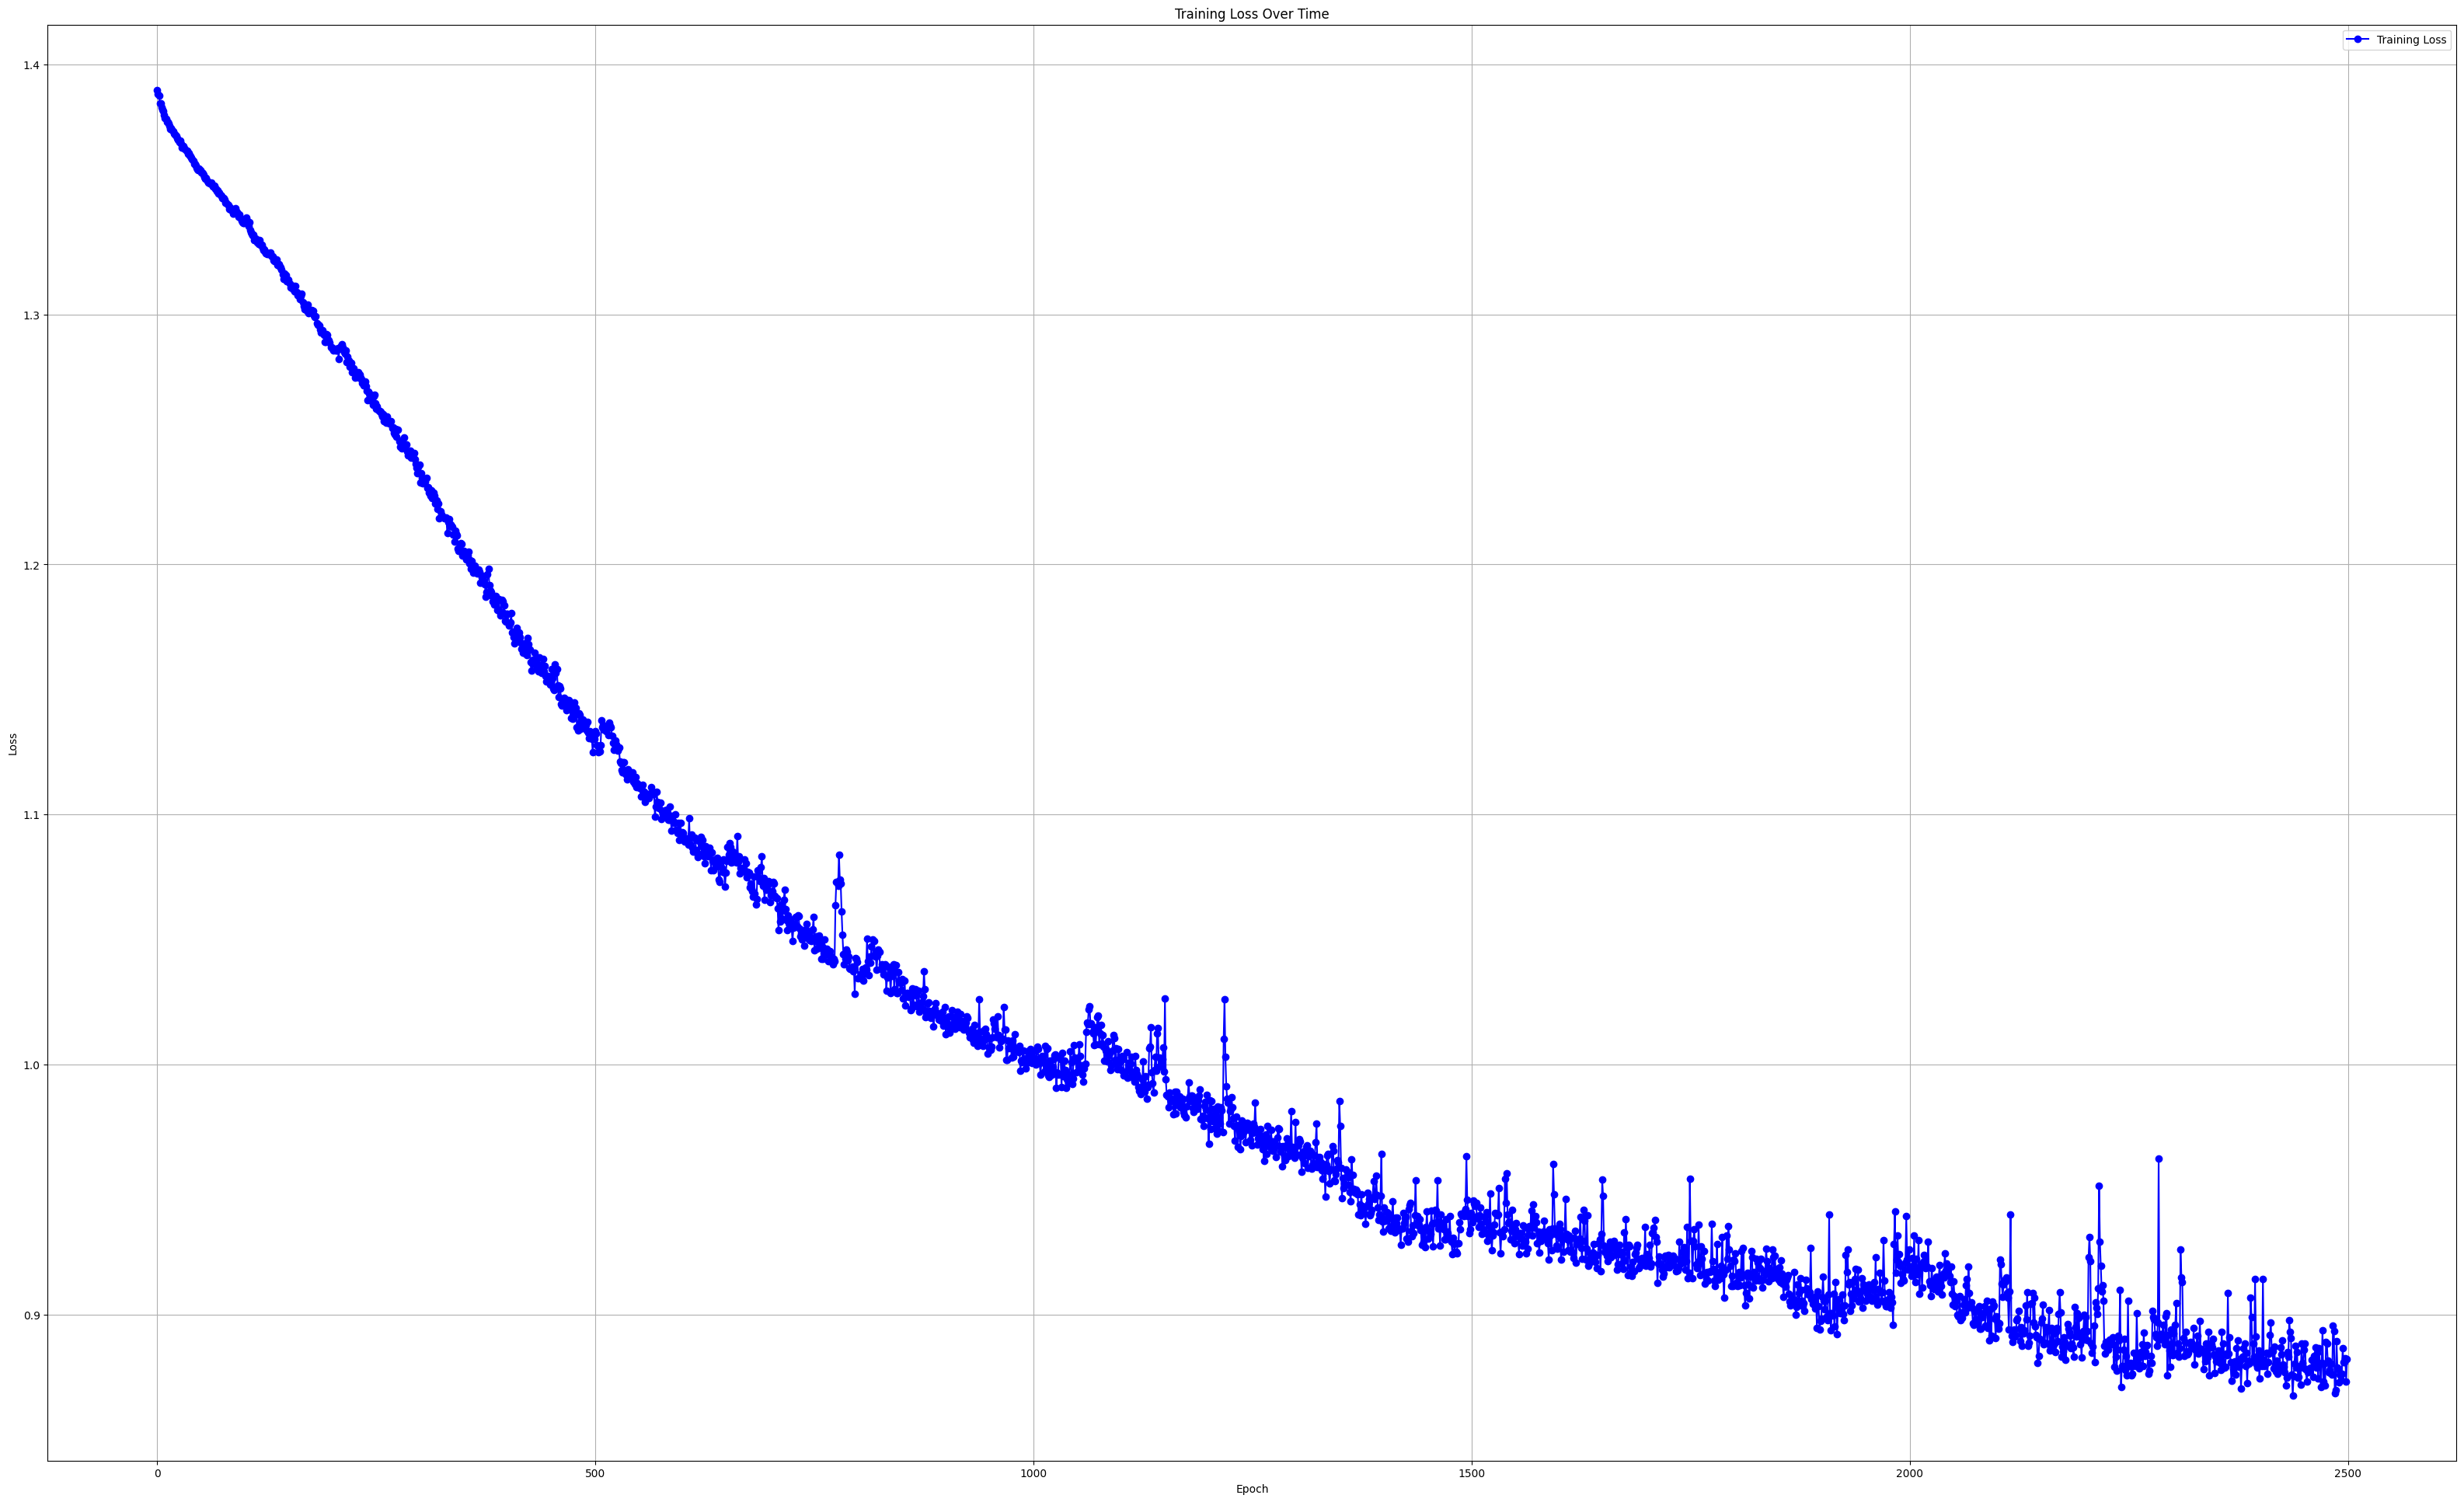

In [ ]:
plot_loss(loss)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import numpy as np

def evaluate(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            sequences = batch["eeg_signal"].to(device)
            labels = batch["class"].to(device)

            # Forward pass
            outputs = model(sequences)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # Collect labels and predictions for additional metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    accuracy = 100 * (total_correct / total_samples)
    average_loss = total_loss / len(dataloader)

    # Convert predictions and labels to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate additional metrics
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)
    #roc_auc = roc_auc_score(all_labels, outputs.softmax(dim=1).cpu().numpy(), multi_class='ovr')

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Average Loss: {average_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    #print(f"ROC-AUC: {roc_auc:.4f}")

    return accuracy, average_loss, precision, recall, f1, balanced_accuracy


In [ ]:
torch.save(model.state_dict(), 'lstm_cnn_model5knns2.pth')

In [ ]:
evaluate(model, test_dataloader)

Test Accuracy: 48.94%
Average Loss: 0.9364
Precision: 0.5053
Recall: 0.4894
F1 Score: 0.4818
Balanced Accuracy: 0.4904


(48.94291754756871,
 0.9364169677098592,
 0.5052739572300584,
 0.4894291754756871,
 0.4818250869541316,
 0.49038507208569904)

In [ ]:
num_classes = 4  # Change this to the actual number of classes in your EEG dataset
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    for batch in test_dataloader:
        sequences = batch["eeg_signal"].to(device)
        labels = batch["class"].to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print per-class accuracy
for i in range(num_classes):
    accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of class {i}: {accuracy * 100:.2f}%')

Accuracy of class 0: 35.12%
Accuracy of class 1: 70.51%
Accuracy of class 2: 40.52%
Accuracy of class 3: 50.00%
